In [1]:
# https://www.kaggle.com/code/zulqarnainali/explained-singel-model-optiver

In [36]:
import gc  # Garbage collection for memory management
import os  # Operating system-related functions
import time  # Time-related functions
import warnings  # Handling warnings
from itertools import combinations  # For creating combinations of elements
from warnings import simplefilter  # Simplifying warning handling

# 📦 Importing machine learning libraries
import joblib  # For saving and loading models
import lightgbm as lgb  # LightGBM gradient boosting framework
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis
from sklearn.metrics import mean_absolute_error  # Metric for evaluation
from sklearn.model_selection import KFold, TimeSeriesSplit  # Cross-validation techniques

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

# 📊 Define flags and variables
is_offline = False  # Flag for online/offline mode
is_train = True  # Flag for training mode
is_infer = True  # Flag for inference mode

In [4]:
# 📂 Read the dataset from a CSV file using Pandas
data_path = '../../data/'
df = pd.read_csv(data_path + 'train.csv')

# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=["target"])

# null 값 처리
df['far_price'] = df['far_price'].fillna(0)
df['near_price'] = df['near_price'].fillna(1)

df = df.dropna().reset_index(drop=True)
# cols_group_by = ['date_id', 'seconds_in_bucket']
# cols_fill_nan = [
#     'imbalance_size', 'reference_price', 'matched_size', 'wap',
#     'bid_price', 'bid_size', 'ask_price', 'ask_size',
#     'stock_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag']
# train_grouped_median = df.groupby(cols_group_by)[cols_fill_nan].transform('median')
# df[cols_fill_nan] = df[cols_fill_nan].fillna(train_grouped_median)

# 📏 Get the shape of the DataFrame (number of rows and columns)
df_shape = df.shape

In [5]:
df.isnull().sum(axis=0)

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
row_id                     0
dtype: int64

In [6]:
# 🧹 Function to reduce memory usage of a Pandas DataFrame
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    
    # 📏 Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)

    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")

    # 🔄 Return the DataFrame with optimized memory usage
    return df

In [7]:
# 🏎️ Import Numba for just-in-time (JIT) compilation and parallel processing
from numba import njit, prange

# 📊 Function to compute triplet imbalance in parallel using Numba
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    # 🔁 Loop through all combinations of triplets
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        
        # 🔁 Loop through rows of the DataFrame
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            # 🚫 Prevent division by zero
            if mid_val == min_val:
                imbalance_features[j, i] = (max_val - mid_val) / 1e-8
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

# 📈 Function to calculate triplet imbalance for given price data and a DataFrame
def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance using the Numba-optimized function
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features

In [8]:
# 📊 Function to generate imbalance features
def imbalance_features(df):
    # import cudf
    # df = cudf.from_pandas(df)
    
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]

    # V1 features
    # Calculate various features using Pandas eval function
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("ask_price + bid_price")/2
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("imbalance_size-matched_size")/df.eval("matched_size+imbalance_size")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    
    # Create features for pairwise price imbalances
    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")
        
    # V2 features
    # Calculate additional features
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1).fillna(0) / (df['matched_size']+1e-8)
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff().fillna(0)
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    
        
    # V3 features
    # Calculate shifted and return features for specific columns
    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        fill_value = df[col].mean()
        for window in [1, 2, 3]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window).fillna(fill_value)
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size']:
        for window in [1, 2, 3]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window).fillna(0)
    # df = df.to_pandas()
    # Replace infinite values with 0
    return df.replace([np.inf, -np.inf], 0)

def numba_imb_features(df):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        
    # Calculate triplet imbalance features using the Numba-optimized function
    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
    return df

# 📅 Function to generate time and stock-related features
def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    df["minute"] = df["seconds_in_bucket"] // 60  # Minutes

    # Map global features to the DataFrame
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

# 🚀 Function to generate all features by combining imbalance and other features
def generate_all_features(df):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    df = numba_imb_features(df)
    # Generate time and stock-related features
    df = other_features(df)
    gc.collect()  # Perform garbage collection to free up memory
    
    # Select and return the generated features
    feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id"]]
    
    return df[feature_name]

In [9]:
# Check if the code is running in offline or online mode
if is_offline:
    # In offline mode, split the data into training and validation sets based on the split_day
    df_train = df[df["date_id"] <= split_day]
    df_valid = df[df["date_id"] > split_day]
    
    # Display a message indicating offline mode and the shapes of the training and validation sets
    print("Offline mode")
    print(f"train : {df_train.shape}, valid : {df_valid.shape}")
else:
    # In online mode, use the entire dataset for training
    df_train = df
    
    # Display a message indicating online mode
    print("Online mode")

Online mode


In [10]:
if is_train:
    global_stock_id_feats = {
        "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
        "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
        "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
        "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
        "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
        "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
    }
    if is_offline:
        df_train_feats = generate_all_features(df_train)
        print("Build Train Feats Finished.")
        df_valid_feats = generate_all_features(df_valid)
        print("Build Valid Feats Finished.")
        df_valid_feats = reduce_mem_usage(df_valid_feats)
    else:
        df_train_feats = generate_all_features(df_train)
        print("Build Online Train Feats Finished.")

    df_train_feats = reduce_mem_usage(df_train_feats)

Build Online Train Feats Finished.


In [11]:
df_train_feats.columns

Index(['stock_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'volume', 'mid_price', 'liquidity_imbalance',
       'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb',
       'reference_price_near_price_imb', 'reference_price_ask_price_imb',
       'reference_price_bid_price_imb', 'reference_price_wap_imb',
       'far_price_near_price_imb', 'far_price_ask_price_imb',
       'far_price_bid_price_imb', 'far_price_wap_imb',
       'near_price_ask_price_imb', 'near_price_bid_price_imb',
       'near_price_wap_imb', 'ask_price_bid_price_imb', 'ask_price_wap_imb',
       'bid_price_wap_imb', 'imbalance_momentum', 'price_spread',
       'spread_intensity', 'price_pressure', 'market_urgency',
       'depth_pressure', 'matched_size_shift_1', 'matched_size_shift_2',
       'matched_size_shift_3', 'imbalance_size_shi

In [12]:
df_train_feats.shape

(5237760, 88)

In [13]:
df_train_feats.isnull().sum(axis=0).sort_values(ascending=False)[:8]

stock_id             0
seconds_in_bucket    0
all_sizes_mean       0
all_prices_mean      0
bid_size_diff_3      0
bid_size_diff_2      0
bid_size_diff_1      0
ask_size_diff_3      0
dtype: int64

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
X_all = scaler.fit_transform(df_train_feats.values)
# X_all = train_df[selected_features].values
y_all = df_train[['target']].values

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision.transforms import transforms

In [17]:
# 장비 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [18]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
valid_dataset = TensorDataset(torch.FloatTensor(X_valid), torch.FloatTensor(y_valid))

In [19]:
batch_size=1024
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [20]:
input_size = df_train_feats.shape[1]
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=512) 
        self.bn1 = nn.BatchNorm1d(num_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=256)
        self.bn2 = nn.BatchNorm1d(num_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=128)
        self.bn3 = nn.BatchNorm1d(num_features=128)
        self.fc4 = nn.Linear(in_features=128, out_features=64)
        self.bn4 = nn.BatchNorm1d(num_features=64)
        self.fc5 = nn.Linear(in_features=64, out_features=32)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self.fc6 = nn.Linear(in_features=32, out_features=1) 
        self.relu = nn.LeakyReLU() # activation layer

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.fc6(x)
        return x

model = Model().to(device)
model

Model(
  (fc1): Linear(in_features=88, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc6): Linear(in_features=32, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [21]:
# 손실 함수
criterion = nn.L1Loss()

In [22]:
# 옵티마이저
optimizer = torch.optim.AdamW(model.parameters(), lr=0.005)

In [23]:
# Scheduler
from torch.optim import lr_scheduler

lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer=optimizer,
    T_0=20,
    T_mult=1,
    eta_min=1e-6
)
lr_scheduler

In [ ]:
# early stopper
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.00001):
        self.best_model = None
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')
        
    def get_best_model(self):
        return self.best_model

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            print(f"New best loss: {validation_loss:>4f}")
            self.min_validation_loss = validation_loss
            self.counter = 0
            self.best_model = model
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
early_stopper = EarlyStopper(patience=15, min_delta=0.0001)

In [24]:
from tqdm.auto import tqdm
epochs = 100

train_epoch_loss = []
valid_epoch_loss = []
for epoch in range(epochs):

    train_iter_loss = []
    bar = tqdm(enumerate(train_loader), total = len(train_loader), desc='Train Loop')
    model.train()
    for idx, (stocks, movements) in bar:
        # with torch.autocast(device_type='cuda', dtype=torch.float64):
        stocks = stocks.to(device)
        movements = movements.to(device)
        outputs = model(stocks)
        loss = criterion(outputs, movements)
        train_iter_loss.append(loss.item())
        optimizer.zero_grad() # 기울기 초기화
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        bar.set_postfix(
            Epoch = epoch,
            Current_loss = loss.item(),
            Train_loss = sum(train_iter_loss)/(idx+1),
            LR = optimizer.param_groups[0]['lr'],
        )
    print(f'Epoch [{epoch+1}/{epochs}] - Train loss : {sum(train_iter_loss)/len(train_loader):.4f}')
    train_epoch_loss.append(sum(train_iter_loss)/len(train_loader))

    model.eval()
    valid_iter_loss = []
    for idx, (stocks, movements) in enumerate(valid_loader):
        # with torch.autocast(device_type='cuda', dtype=torch.float16):
        with torch.no_grad():
            stocks = stocks.to(device)
            movements = movements.to(device)
            outputs = model(stocks)
            loss = criterion(outputs, movements)
            valid_iter_loss.append(loss.item())
    print(f'Epoch [{epoch+1}/{epochs}] - Valid loss : {sum(valid_iter_loss)/len(valid_loader):.4f}')
    valid_epoch_loss.append(sum(valid_iter_loss)/len(valid_loader))
    if early_stopper.early_stop(test_loss, model) or time.time() - t1 > 60*60*8:  
        model = early_stopper.get_best_model()
        break
    gc.collect()

Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [1/100] - Train loss : 6.2932
Epoch [1/100] - Valid loss : 6.2782


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [2/100] - Train loss : 6.2748
Epoch [2/100] - Valid loss : 6.2615


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [3/100] - Train loss : 6.2660
Epoch [3/100] - Valid loss : 6.2509


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [4/100] - Train loss : 6.2598
Epoch [4/100] - Valid loss : 6.2454


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [5/100] - Train loss : 6.2543
Epoch [5/100] - Valid loss : 6.2426


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [6/100] - Train loss : 6.2501
Epoch [6/100] - Valid loss : 6.2399


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [7/100] - Train loss : 6.2465
Epoch [7/100] - Valid loss : 6.2366


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [8/100] - Train loss : 6.2426
Epoch [8/100] - Valid loss : 6.2353


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [9/100] - Train loss : 6.2397
Epoch [9/100] - Valid loss : 6.2324


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [10/100] - Train loss : 6.2368
Epoch [10/100] - Valid loss : 6.2346


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [11/100] - Train loss : 6.2343
Epoch [11/100] - Valid loss : 6.2316


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [12/100] - Train loss : 6.2318
Epoch [12/100] - Valid loss : 6.2303


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [13/100] - Train loss : 6.2299
Epoch [13/100] - Valid loss : 6.2347


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [14/100] - Train loss : 6.2279
Epoch [14/100] - Valid loss : 6.2289


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [15/100] - Train loss : 6.2260
Epoch [15/100] - Valid loss : 6.2337


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [16/100] - Train loss : 6.2240
Epoch [16/100] - Valid loss : 6.2316


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [17/100] - Train loss : 6.2228
Epoch [17/100] - Valid loss : 6.2269


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [18/100] - Train loss : 6.2217
Epoch [18/100] - Valid loss : 6.2302


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [19/100] - Train loss : 6.2204
Epoch [19/100] - Valid loss : 6.2314


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [20/100] - Train loss : 6.2195
Epoch [20/100] - Valid loss : 6.2334


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [21/100] - Train loss : 6.2185
Epoch [21/100] - Valid loss : 6.2313


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [22/100] - Train loss : 6.2173
Epoch [22/100] - Valid loss : 6.2251


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [23/100] - Train loss : 6.2165
Epoch [23/100] - Valid loss : 6.2310


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [24/100] - Train loss : 6.2152
Epoch [24/100] - Valid loss : 6.2269


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [25/100] - Train loss : 6.2150
Epoch [25/100] - Valid loss : 6.2305


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [26/100] - Train loss : 6.2137
Epoch [26/100] - Valid loss : 6.2301


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [27/100] - Train loss : 6.2130
Epoch [27/100] - Valid loss : 6.2274


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [28/100] - Train loss : 6.2123
Epoch [28/100] - Valid loss : 6.2275


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [29/100] - Train loss : 6.2117
Epoch [29/100] - Valid loss : 6.2286


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [30/100] - Train loss : 6.2115
Epoch [30/100] - Valid loss : 6.2281


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

Epoch [31/100] - Train loss : 6.2107
Epoch [31/100] - Valid loss : 6.2293


Train Loop:   0%|          | 0/4092 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
np.argmin(train_epoch_loss), min(train_epoch_loss), np.argmin(valid_epoch_loss), min(valid_epoch_loss)

(30, 6.210712981014308, 21, 6.225063301601018)

<Axes: >

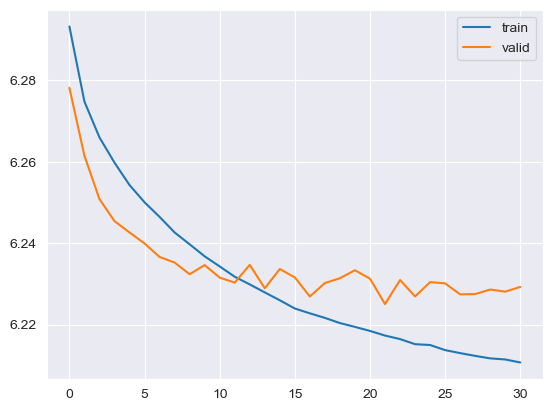

In [26]:
sns.lineplot(train_epoch_loss, label='train')
sns.lineplot(valid_epoch_loss, label='valid')

In [28]:
def predict(X, model):
    model.eval()
    with torch.no_grad():
        pred = model(X)
    return pred.detach().cpu().numpy().flatten()

In [34]:
iter_ = iter(valid_loader)
next(iter_)
X_, y_ = next(iter_)
pred = predict(X_.to(device), model)
res = pd.DataFrame({
    "target":y_.flatten().cpu(), 
    "pred":pred
})
res["err"] = np.abs(res["target"] - res["pred"])
res

,target,pred,err
0,-0.180006,1.784048,1.964054
1,9.419918,0.835426,8.584492
2,0.020266,-4.546921,4.567186
3,1.850128,-0.081980,1.932109
4,9.119511,-0.535863,9.655374
...,...,...,...
1019,7.380247,-2.312257,9.692505
1020,-10.179877,0.596918,10.776795
1021,-3.010035,-0.306295,2.703740
1022,-6.549954,0.916428,7.466382


(-32.19690227508545, 30.354280471801758)

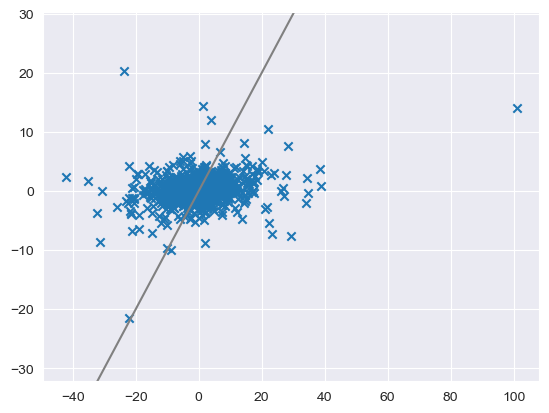

In [37]:
plt.plot([res.target.min(), res.target.max()], [res.target.min(), res.target.max()], color="gray")
plt.scatter(res.target, res.pred, marker="x")
plt.ylim(res.pred.min()*1.5,res.pred.max()*1.5)